# ML_Ng Homework 5

In [9]:
%matplotlib inline
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

##  Part 1: Loading and Visualizing Data 
We start the exercise by first loading and visualizing the dataset.
You will be working with a dataset that contains handwritten digits.

### Load Training Data

In [10]:
mat_contents = sio.loadmat('ex5/ex5data1.mat')
Xtrain = mat_contents['X']
ytrain = mat_contents['y']
Xval = mat_contents['Xval']
yval = mat_contents['yval']
Xtest = mat_contents['Xtest']
ytest = mat_contents['ytest']
m,n = Xtrain.shape

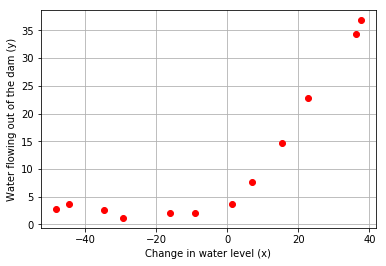

In [11]:
fig, ax = plt.subplots()
ax.plot(Xtrain,ytrain, 'ro')
ax.set(xlabel= 'Change in water level (x)', ylabel='Water flowing out of the dam (y)')
ax.grid()
plt.show()

## Part 2, 3, & 4: Regularlized Linear Cost and Gradient
This part is solving with scipy for fun.

In [12]:
def cost_fn(theta, X, y, lamb):
    m = y.size
    theta = np.matrix(theta).reshape((len(theta),1))
    h = X @ theta
    J = 1 / (2 * m) * (h - y).T.dot(h - y)
    reg = lamb/(2*m) * np.sum(np.power(theta[1:,:],2))
    return J + reg
def grad_fn(theta, X, y, lamb):
    m = y.size
    theta = np.matrix(theta).reshape((len(theta),1))
    h = X @ theta
    grad_reg = lamb/m * theta
    grad = 1/m * ((h-y).T @ X).T + grad_reg
    grad[0] = grad[0] - grad_reg[0]    
    return np.resize(grad,(grad.size,))

def cost_grad_function_reg(theta, X, y, lamb):
    J = cost_fn(theta,X,y,lamb)
    grad = grad_fn(theta,X,y,lamb)
    return J, grad

theta = np.ones((2,1))
lamb = 1
X_b = np.column_stack((np.ones((m,1)), Xtrain))
J, grad = cost_grad_function_reg(theta,X_b,ytrain,lamb)
print('Expected cost at theta = [1 ; 1]: 303.993192');
print('Cost:', J)
print('\nExpected gradients: [-15.303016; 598.250744]');
print('Gradients:\n', grad);

# Part 4, train it. The data is non-linear so it won't give a good fit.
theta = np.zeros(X_b.shape[1])
lamb = 0
from scipy.optimize import minimize
result = minimize(fun=cost_grad_function_reg, x0=theta, jac=True, method='CG', options={'maxiter': 200}, args=(X_b, ytrain, lamb)) 
result

Expected cost at theta = [1 ; 1]: 303.993192
Cost: [[303.99319222]]

Expected gradients: [-15.303016; 598.250744]
Gradients:
 [-15.30301567 598.25074417]


     fun: 22.373906495108915
     jac: array([ 4.29286236e-14, -4.84799585e-13])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 2
    njev: 5
  status: 0
 success: True
       x: array([13.08790351,  0.36777923])

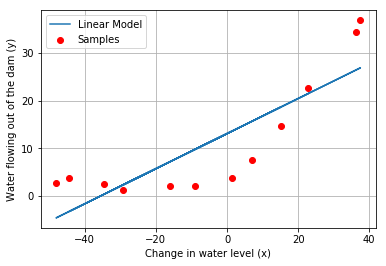

In [13]:
h = X_b @ result.x
fig, ax = plt.subplots()
ax.scatter(Xtrain, ytrain, c='red',label='Samples')
ax.plot(Xtrain, h, label='Linear Model')
ax.set(xlabel= 'Change in water level (x)', ylabel='Water flowing out of the dam (y)')
ax.grid()
ax.legend(loc='best')
plt.show()

## Part 5: Learning Curve for Linear Regression
Using scikit-learn's Ridge solver for its learning curve function. Going forward I'll be combining train, val, and test sets into _all because learning and validation curves have their own built-in in train/cv/test splitter.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

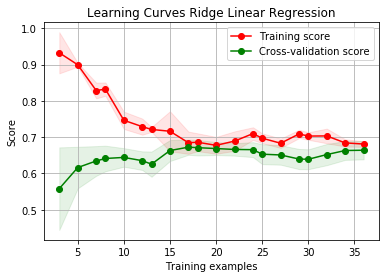

In [14]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

from sklearn.linear_model import Ridge
lamb = 0
estimator = Ridge(alpha=lamb, max_iter=200, normalize=False)
title = "Learning Curves Ridge Linear Regression"
X_all = np.append(Xtrain,Xval, axis=0)
X_all = np.append(X_all,Xtest, axis=0)
y_all = np.append(ytrain,yval, axis=0)
y_all = np.append(y_all,ytest, axis=0)
plot_learning_curve(estimator, title, X_all, y_all)

## Part 6: Feature mapping for Polynomial Regression
Let's play with Stochastic Gradient Descent here, so we get fewer warnings.

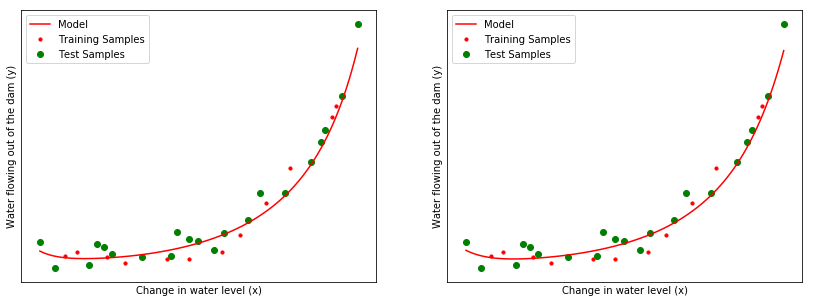

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor

p = 12

X_poly = PolynomialFeatures(p).fit_transform(Xtrain)
X_poly = StandardScaler().fit_transform(X_poly)

X_poly_test = PolynomialFeatures(p).fit_transform(Xtest)
X_poly_test = StandardScaler().fit_transform(X_poly_test)

X_poly_val = PolynomialFeatures(p).fit_transform(Xval)
X_poly_val = StandardScaler().fit_transform(X_poly_val)

estimator = SGDRegressor(loss="squared_loss", penalty="none", max_iter=200).fit(X_poly,np.ravel(ytrain))
xs = np.linspace(min(Xtest), max(Xtest), 120).reshape(-1, 1)
xs_p = PolynomialFeatures(p).fit_transform(xs)
xs_p = StandardScaler().fit_transform(xs_p)

plt.figure(figsize=(14, 5))
ax = plt.subplot(1, 2, 1)
plt.setp(ax, xticks=(), yticks=())
ax.scatter(Xtrain,ytrain,s=10, c='red', label='Training Samples')
ax.scatter(Xtest,ytest, c='green', label='Test Samples')
ax.plot(xs,estimator.predict(xs_p), c='red', label='Model')
ax.set(xlabel= 'Change in water level (x)', ylabel='Water flowing out of the dam (y)')
ax.grid()
ax.legend(loc='best')

p = 8

X_poly = PolynomialFeatures(p).fit_transform(Xtrain)
X_poly = StandardScaler().fit_transform(X_poly)

X_poly_test = PolynomialFeatures(p).fit_transform(Xtest)
X_poly_test = StandardScaler().fit_transform(X_poly_test)

X_poly_val = PolynomialFeatures(p).fit_transform(Xval)
X_poly_val = StandardScaler().fit_transform(X_poly_val)

# Let's view its fit!
estimator = SGDRegressor(loss="squared_loss", penalty="none", max_iter=200).fit(X_poly,np.ravel(ytrain))
xs = np.linspace(min(Xtest), max(Xtest), 120).reshape(-1, 1)
xs_p = PolynomialFeatures(p).fit_transform(xs)
xs_p = StandardScaler().fit_transform(xs_p)

ax = plt.subplot(1, 2, 2)
plt.setp(ax, xticks=(), yticks=())
ax.scatter(Xtrain,ytrain,s=10, c='red', label='Training Samples')
ax.scatter(Xtest,ytest, c='green', label='Test Samples')
ax.plot(xs,estimator.predict(xs_p), c='red', label='Model')
ax.set(xlabel= 'Change in water level (x)', ylabel='Water flowing out of the dam (y)')
ax.grid()
ax.legend(loc='best')

plt.show()

## Part 7: Learning curve for Polynomial

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

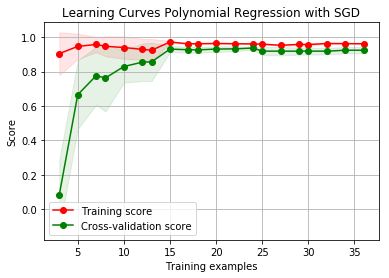

In [16]:

title = "Learning Curves Polynomial Regression with SGD"
X_poly_all = np.append(X_poly,X_poly_val, axis=0)
X_poly_all = np.append(X_poly_all,X_poly_test, axis=0)
plot_learning_curve(estimator, title, X_poly_all, np.ravel(y_all))

## Part 8: Validation Curve for Selecting Lambda
Still using SGDRegressor

NameError: name 'param_range' is not defined

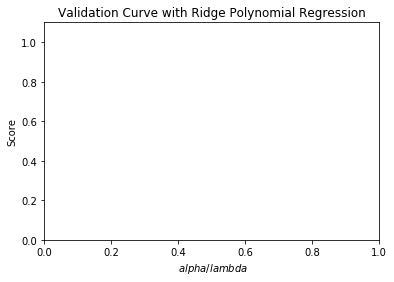

In [17]:
from sklearn.model_selection import validation_curve
alpha_range = np.logspace(-7, 3, 10)
estimator.penalty = "l2"
train_scores, test_scores = validation_curve(estimator, X_poly_all, np.ravel(y_all), param_name="alpha", param_range=alpha_range)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Ridge Polynomial Regression")
plt.xlabel("$\ alpha/lambda $")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

lamb = alpha_range[np.argmax(test_scores_mean)]
print('best score for lambda = ')
print(lamb)

## Part 9: Computing Test Set Error
for best lambda chosen from previous validation curve

In [ ]:
estimator.alpha = lamb
estimator.fit(X_poly, np.ravel(ytrain))

plt.figure(figsize=(14, 5))
ax = plt.subplot(1, 2, 1)
plt.setp(ax, xticks=(), yticks=())
ax.scatter(Xtrain,np.ravel(ytrain),s=10, c='red', label='Training Samples')
ax.scatter(Xtest,np.ravel(ytest), c='green', label='Test Samples')
ax.plot(xs,estimator.predict(xs_p), c='red', label='Model')
ax.set(xlabel= 'Change in water level (x)', ylabel='Water flowing out of the dam (y)')
ax.grid()
ax.legend(loc='best')